## Simulating LSST-like image time-series of lensed type Ia supernovae

### Import python libraries, LSST characteristics and functions

In [1]:
from class_telescope import Telescope
from image_time_series import simulate_time_series_images
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Parameter distributions 

Sample $z_l$, $z_s$ and $\theta_E$ from MC sample from Wojtak et al. (2019).


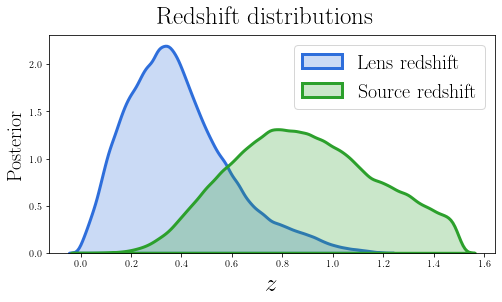

In [2]:
# ---------------------------------
telescope = 'LSST'
bandpasses = ['r', 'i', 'z', 'y']
# ---------------------------------

lsst = Telescope(telescope, bandpasses)

z_source_list_, z_lens_list_, theta_E_list_ = lsst.load_z_theta(theta_min=0.1)

lsst.plot_redshifts(z_lens_list_, z_source_list_)

### Seeing distributions
Sample the PSF from the predicted seeing distribution for the <b> baseline v2.0 </b> observing strategy for 10 years.

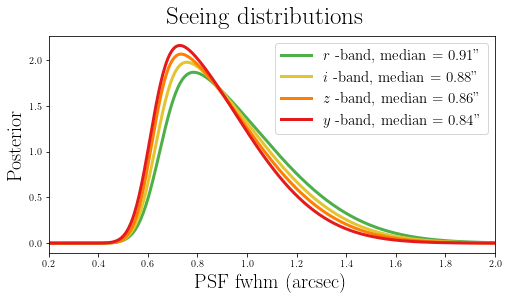

In [3]:
lsst.plot_seeing_distributions()


### Cadence

Sample the cadence from the predicted distribution for the <b> baseline v2.0 </b> observing strategy for the LSST Wide, Fast, Deep survey from Catarina Alves' simulations.


100%|██████████████████████████████████████████| 64/64 [00:00<00:00, 647.10it/s]


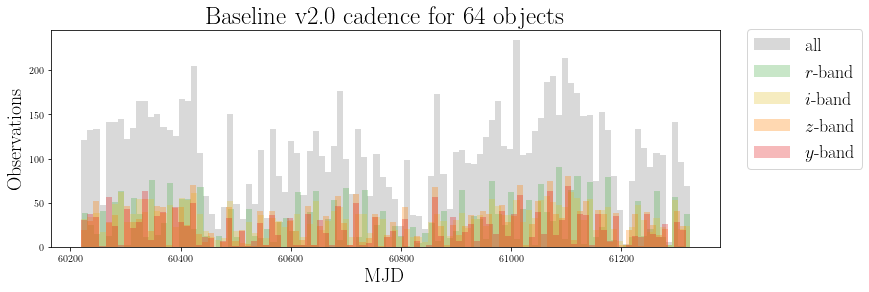

In [4]:
obs_times, obs_filters = lsst.load_cadence(small_sample=True)

obs_all, obs_r, obs_i, obs_z, obs_y = lsst.get_total_obs_times(obs_times, obs_filters)

lsst.plot_cadence(obs_times, obs_all, obs_r, obs_i, obs_z, obs_y)

### Generation of training and test sets


  0%|                                                     | 0/1 [00:00<?, ?it/s]

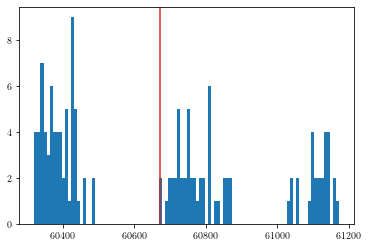

Detectable! Number of cadence tries:  1
 
Lens redshift:  0.49
Supernova redshift:  1.33
Einstein radius:  0.63
Time delays:  [ 0.   37.74] days
Macro magnification:  [4.6  3.02]
Microlensing contribution at peak (magnitudes):  0.0
Hubble constant:  33.63
Time-delay distance:  7169.82
Peak brightness images for r,i,z,y bands:
[[24.87 26.68]
 [23.07 23.56]
 [23.63 23.09]
 [22.44 22.82]]
 


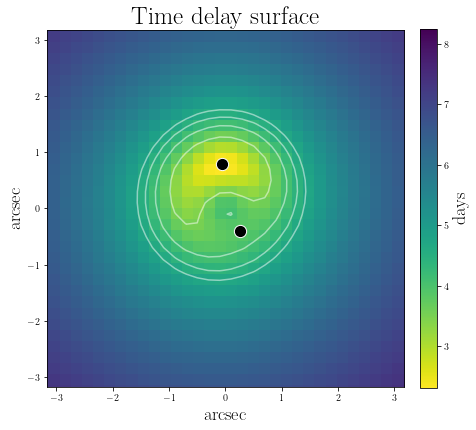

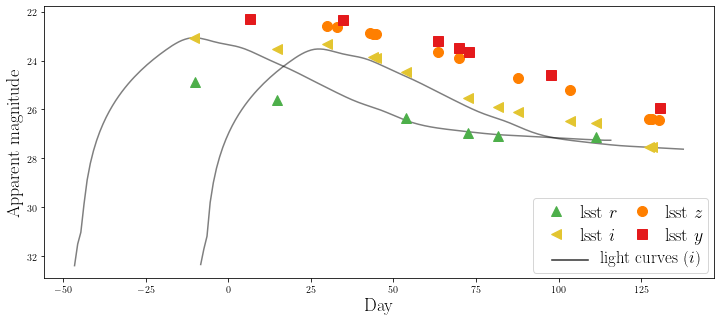

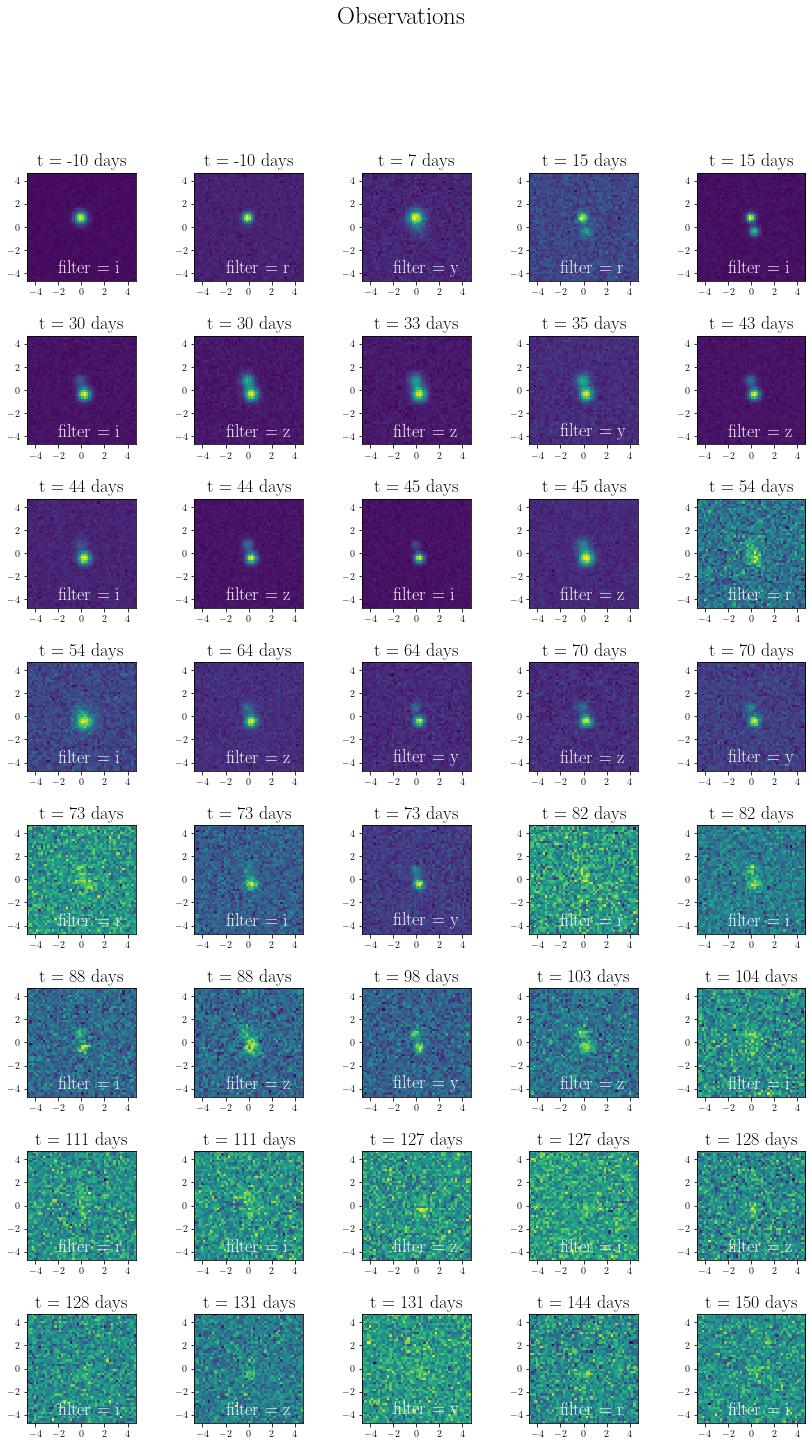

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.88s/it]

Timing results
Len:  1 156 150 1 0 0 0 0 1 1 1
 
Mean time:  0.01495814323425293 0.00042193058209541516 0.004281541506449381 0.0020830631256103516 nan nan nan nan 0.3150169849395752 0.00034618377685546875 3.794062852859497
 
Done!
Simulating images took  6.0 seconds ( 0.0 hours) to complete.
Number of image-time series generated:  1
Number of configurations tried:  1
Number of attempts:  156
 


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.48s/it]

                                         time_series  z_source    z_lens  \
0  [[[0.7905350914247398, 0.548193815038646, 0.60...  1.328267  0.490556   

          H0   theta_E                                           obs_peak  \
0  33.629754  0.634027  [[24.873246158959052, 26.67550647898415], [23....   

                                 macro_mag  source_x  source_y  \
0  [4.597377293114161, 3.0150422999703843] -0.045449  0.137152   

                 time_delay  ...  gamma_lens  e1_lens   e2_lens  \
0  [0.0, 37.74155100231016]  ...    1.947571  0.07146 -0.060263   

                                         time_stamps  g1_shear  g2_shear  \
0  [0.0, 0.012600000001839362, 16.955999999998312...   0.01035  0.005788   

  micro_kappa  micro_gamma  micro_s micro_peak  
0         NaN          NaN      NaN        0.0  

[1 rows x 23 columns]


In [5]:
num_samples = 1               # Total number of lens systems to be generated  
batch_size = 1                # Number of lens systems that is saved together in a batch
batch = 1                     # Starting number of the batch
num_images = 2                # Choose between 2 (for doubles) and 4 (for quads)
obs_upper_limit = 40          # Upper limit of number of observations
obs_lower_limit = 5           # Lower limit of number of observations
fixed_H0 = False              # Bool, if False: vary H0. if True: fix H0 to 70 km/s/Mpc (for the evaluation set)
add_microlensing = False      # Bool, if False: Only macro magnification. if True: Add effects of microlensing

Show = True                   # Bool, if True: Show figures and print information about the lens systems
Save = False                  # Bool, if True: Save image time-series
path = "../processed_data/Cadence_microlensing_evaluationset_doubles2/" # Path to folder in which to save the results


timings, mmtimings = simulate_time_series_images(batch_size, batch,  num_samples, num_images, obs_times,
                                                 obs_filters, obs_all, z_source_list_, z_lens_list_, theta_E_list_, 
                                                 add_microlensing, telescope, bandpasses, 
                                                 obs_lower_limit, obs_upper_limit, fixed_H0, Show, Save, path)


[0.017477035522460938, 0.0004587644859865138, 0.0030732482444239028, 0.0021895170211791992, nan, nan, nan, nan, 0.3402564071473621, 0.00013780593872070312, 3.962705135345459, nan, nan]


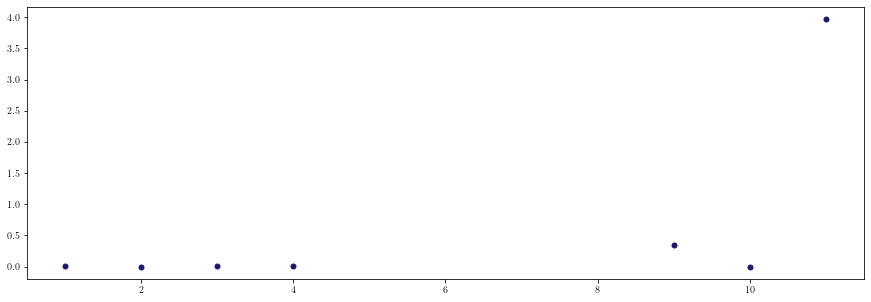

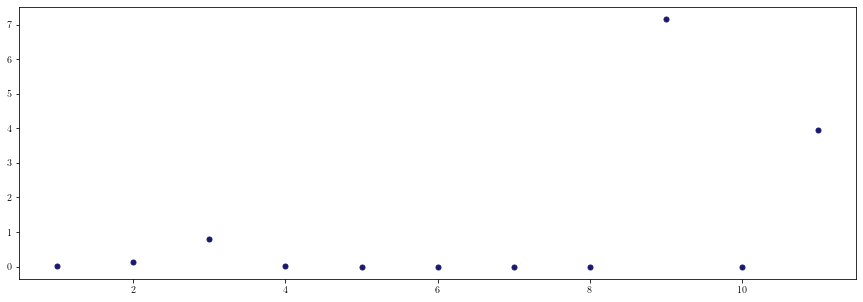

In [6]:
averages = [np.mean(t) for t in timings]
print(averages)
sums = [np.sum(t) for t in timings]
periods = [1,2,3,4,5,6,7,8,9,10,11]

plt.figure(1, figsize=(15, 5))
plt.plot(periods, averages[:11], '.', ms=10, color='midnightblue')

plt.figure(2, figsize=(15, 5))
plt.plot(periods, sums[:11], '.', ms=10, color='midnightblue')


0.0 0.0
nan nan
nan


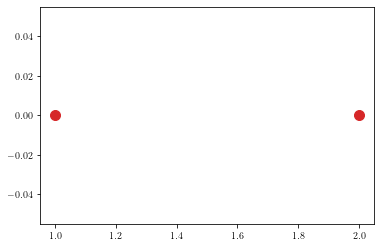

In [7]:
plt.figure(3)
plt.plot([1,2], sums[11:], '.', ms=20, color="C3")
print(sums[11], sums[12])
print(averages[11], averages[12])
print(averages[6])

In [8]:
timings_200 = timings.copy()

[nan, nan, nan, nan, nan, nan, nan]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


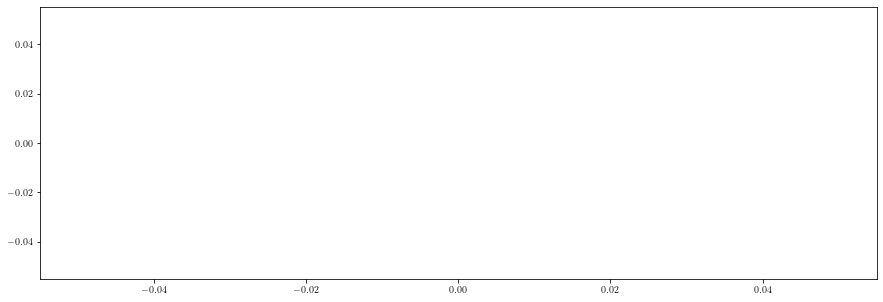

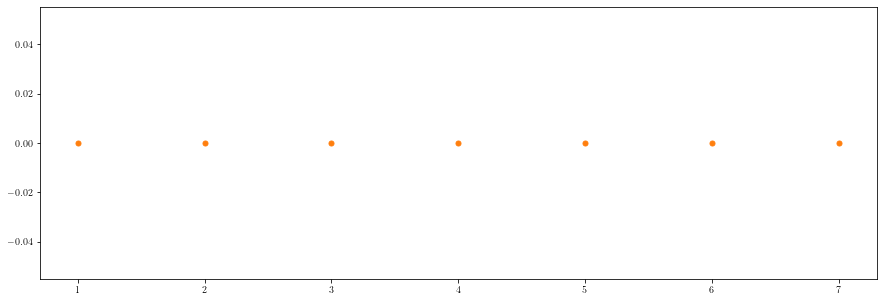

In [9]:
mmaverages = [np.mean(t) for t in mmtimings]
mmsums = [np.sum(t) for t in mmtimings]
mmperiods = [1,2,3,4,5,6,7]
print(mmaverages)
print(mmsums)

plt.figure(4, figsize=(15, 5))
plt.plot(mmperiods, mmaverages, '.', ms=10, color='C1')

plt.figure(5, figsize=(15, 5))
plt.plot(mmperiods, mmsums, '.', ms=10, color='C1')
